# 3. Load dataset from DataCube <img align="right" src="image/gistda.png" width="200" height="200">
 - [List product in datacube](#List-product-in-datacube)
 - [List specific product](#List-specific-product)
 - [Load dataset from datacube](#Load-dataset-from-datacube)
 - [Load by specific bands](#Load-by-specific-bands)
 
 
<table class="ee-notebook-buttons" align="left">
    <td><a target="_parent"  href="https://nbviewer.org/github/Pathakorn40/rice-detection/blob/main/Tutorial/Load_data.ipynb"><img width=26px src="https://upload.wikimedia.org/wikipedia/commons/thumb/3/38/Jupyter_logo.svg/883px-Jupyter_logo.svg.png" />Notebook Viewer</a></td>
</table>

In [13]:
%matplotlib inline

from pystac_client import Client
from odc.stac import configure_rio, stac_load
from dask.distributed import Client as DaskClient
import matplotlib.pyplot as plt

import folium
import folium.plugins
import geopandas as gpd
import shapely.geometry

client = DaskClient()
client

/home/peraphat/miniconda3/envs/dreamriver/lib/python3.9/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 36597 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:36597/status,
Dashboard: http://127.0.0.1:36597/status,Workers: 4
Total threads: 8,Total memory: 39.15 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:40465,Workers: 4
Dashboard: http://127.0.0.1:36597/status,Total threads: 8
Started: Just now,Total memory: 39.15 GiB
Comm: tcp://127.0.0.1:40043,Total threads: 2
Dashboard: http://127.0.0.1:34305/status,Memory: 9.79 GiB
Nanny: tcp://127.0.0.1:42675,


### Load dataset from datacube

In [5]:
# Set parameters for query

# define AOI
lat = 11.800
lon = 99.790

# buffer distance
lon_buffer = 0.05
lat_buffer = 0.05

# date range for analysis
time_range = ("2015-01-01","2015-01-31")

# Compute the bounding box for the study area
study_area = (lon - lon_buffer, lat - lat_buffer, lon + lon_buffer, lat + lat_buffer)

#set collection configuration
bbox = [100.5, 13.60, 100.70, 13.80]
start_date = "2020-08-20"
end_date = "2020-08-30"
collections = ["LANDSAT8_SR_C2L2"]
config = {
    "LANDSAT8_SR_C2L2": {
        "assets": {
            "*": {
                "data_type": "uint16",
                "nodata": 0,
                "unit": "unitless",
            },
            "aerosol_qa": {
                "data_type": "uint8",
                "nodata": 0,
                "unit": "bit",
            },
            "pixel_qa": {
                "data_type": "uint16",
                "nodata": 0,
                "unit": "bit",
            },
            "radsat_qa": {
                "data_type": "uint16",
                "units": "bit",
                "nodata": 0,
            },
        },
    }
}


In [10]:
def convert_bounds(bbox, invert_y=False):
    """
    Helper method for changing bounding box representation to leaflet notation

    ``(lon1, lat1, lon2, lat2) -> ((lat1, lon1), (lat2, lon2))``
    """
    x1, y1, x2, y2 = bbox
    if invert_y:
        y1, y2 = y2, y1
    return ((y1, x1), (y2, x2))

In [11]:
# connect to the GISTDA ODC STAC Catalog
catalog = Client.open(url="http://110.78.252.138/stac")
query = catalog.search(
    bbox=bbox, collections=collections, datetime=f"{start_date}/{end_date}"
)
items = list(query.items())
print(f"Found: {len(items):d} datasets")
for ds in items:
    print(ds.to_dict()['properties']['title'])

Found: 2 datasets
LC08_L2SR_129050_20200829_20200906_02_T1
LC08_L2SR_129051_20200829_20200906_02_T1


#### Dispaly Area of interest

In [15]:
from branca.element import Figure

stac_json = query.item_collection_as_dict()
gdf = gpd.GeoDataFrame.from_features(stac_json, "epsg:4326")
fig = Figure(width="1200px", height="500px")
map1 = folium.Map()
fig.add_child(map1)

folium.GeoJson(
    shapely.geometry.box(*bbox),
    style_function=lambda x: dict(fill=False, weight=2, opacity=0.7, color="red"),
    name="Query",
).add_to(map1)

gdf.explore(
    "landsat:landsat_scene_id",
    categorical=True,
    tooltip=[
        "landsat:landsat_scene_id",
        "datetime",
        "eo:cloud_cover",
    ],
    popup=True,
    style_kwds=dict(fillOpacity=0.1, width=2),
    name="STAC",
    m=map1,
)

map1.fit_bounds(bounds=convert_bounds(gdf.unary_union.bounds))
display(fig)

/tmp/ipykernel_1391665/272048252.py:29: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  map1.fit_bounds(bounds=convert_bounds(gdf.unary_union.bounds))


### Load data

In [16]:
# Loading data using stac_load()

ds = stac_load(
    items,
    bands=['blue','green','red',"nir"],
    stac_cfg=config,
    chunks={},
    groupby="solar_day",
    bbox=bbox,
)
ds

<xarray.Dataset> Size: 4MB
Dimensions:      (y: 743, x: 727, time: 1)
Coordinates:
  * y            (y) float64 6kB 1.526e+06 1.526e+06 ... 1.504e+06 1.504e+06
  * x            (x) float64 6kB 6.621e+05 6.622e+05 ... 6.839e+05 6.839e+05
    spatial_ref  int32 4B 32647
  * time         (time) datetime64[ns] 8B 2020-08-29T03:37:54
Data variables:
    blue         (time, y, x) uint16 1MB dask.array<chunksize=(1, 743, 727), meta=np.ndarray>
    green        (time, y, x) uint16 1MB dask.array<chunksize=(1, 743, 727), meta=np.ndarray>
    red          (time, y, x) uint16 1MB dask.array<chunksize=(1, 743, 727), meta=np.ndarray>
    nir          (time, y, x) uint16 1MB dask.array<chunksize=(1, 743, 727), meta=np.ndarray>

### Load by specific bands

In [11]:
# set query for load data
query = {
    'y': lat_range,
    'x': lon_range,
    'time': time_range,
    'measurements': ['red', 'green', 'blue', 'nir'],
    'resolution': (-30, 30),
    'output_crs': 'epsg:32647',
    'group_by':'solar_day'
}

### Plot example image of dataset

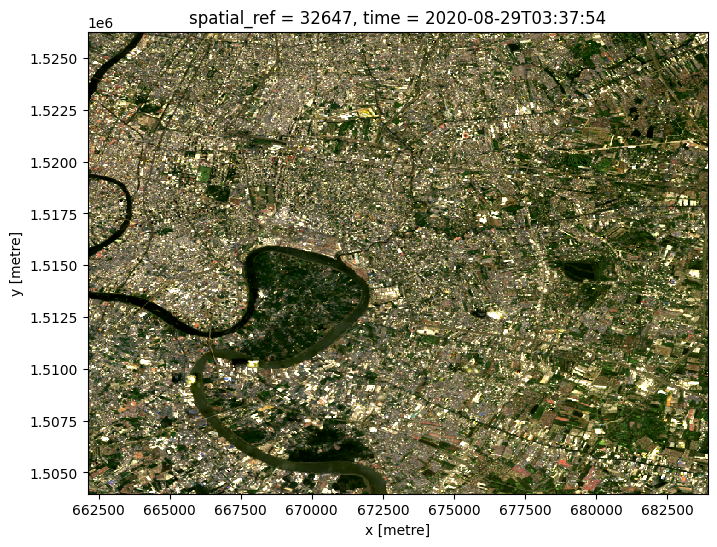

In [17]:
from dream_river.plotimg import rgb

rgb(ds, bands=['red','green', 'blue'], index =0) 

# index = 0 : First timestep.